In [177]:
import pandas as pd
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
!pip install dash
import dash
from dash import dcc, html
import plotly.figure_factory as ff
import numpy as np
!pip install prophet
from prophet import Prophet
import seaborn as sns

In [178]:
# Load the dataset
file_path = "STN Data Set.xlsx"

In [179]:
# Load data from sheets
security_df = pd.read_excel(file_path, sheet_name="Security Q Time")
retail_df = pd.read_excel(file_path, sheet_name="Retail")
sickness_df = pd.read_excel(file_path, sheet_name="Sickness")

In [180]:
# Convert date columns to datetime format for proper time-based analysis
security_df["Security Date"] = pd.to_datetime(security_df["Security Date"], errors='coerce')
retail_df["Scheduled Date"] = pd.to_datetime(retail_df["Scheduled Date"], errors='coerce')
sickness_df["First Day"] = pd.to_datetime(sickness_df["First Day"], errors='coerce')
sickness_df["Last Day"] = pd.to_datetime(sickness_df["Last Day"], errors='coerce')

In [181]:
# Data validation: Checking for missing values in each dataset
print("Missing values check:")
print("Security Data:")
print(security_df.isnull().sum())
print("Retail Data:")
print(retail_df.isnull().sum())
print("Sickness Data:")
print(sickness_df.isnull().sum())

Missing values check:
Security Data:
Security Date    0
Terminal Name    0
QTime            0
dtype: int64
Retail Data:
Scheduled Date             0
Terminal Name              0
Store Reporting Level 1    0
Income Amt - Concession    0
Budget Income              0
Net Sales Amt              0
Budget Sales               0
Transaction Quantity       0
ATV                        0
dtype: int64
Sickness Data:
Absence Type       0
quantityInDays     0
quantityInHours    0
First Day          0
Last Day           0
Terminal Name      0
dtype: int64


In [182]:
# Check for outliers using descriptive statistics
print("\nOutlier Detection - Summary Statistics:")
print("Security Data:")
print(security_df.describe())
print("Retail Data:")
print(retail_df.describe())
print("Sickness Data:")
print(sickness_df.describe())


Outlier Detection - Summary Statistics:
Security Data:
                       Security Date       QTime
count                            729  729.000000
mean   2023-12-31 00:00:00.000000256  280.593278
min              2023-09-01 00:00:00  124.000000
25%              2023-10-31 00:00:00  208.000000
50%              2023-12-31 00:00:00  259.000000
75%              2024-03-01 00:00:00  336.000000
max              2024-04-30 00:00:00  766.000000
std                              NaN   99.451591
Retail Data:
                      Scheduled Date  Income Amt - Concession  Budget Income  \
count                           3159              3159.000000    3159.000000   
mean   2024-01-30 00:00:00.000000256             17481.808756   41971.127937   
min              2023-10-01 00:00:00              -250.000000   -2559.105100   
25%              2023-11-30 00:00:00              2000.420000    4812.817250   
50%              2024-01-30 00:00:00             14912.850000   36167.757700   
75%       

In [183]:
# Check for data consistency in categorical columns
print("\nUnique Values Check:")
print("Security Terminal Names:", security_df["Terminal Name"].unique())
print("Retail Terminal Names:", retail_df["Terminal Name"].unique())
print("Sickness Terminal Names:", sickness_df["Terminal Name"].unique())



Unique Values Check:
Security Terminal Names: ['Terminal A' 'Terminal B' 'Terminal C']
Retail Terminal Names: ['GTI' 'Terminal A' 'Terminal B' 'Terminal C']
Sickness Terminal Names: ['Terminal A' 'Terminal C' 'Terminal B']


In [184]:
# Check for inconsistencies in categorical values
print("\nData Type Consistency Check:")
print(security_df.dtypes)
print(retail_df.dtypes)
print(sickness_df.dtypes)


Data Type Consistency Check:
Security Date    datetime64[ns]
Terminal Name            object
QTime                   float64
dtype: object
Scheduled Date             datetime64[ns]
Terminal Name                      object
Store Reporting Level 1            object
Income Amt - Concession           float64
Budget Income                     float64
Net Sales Amt                     float64
Budget Sales                      float64
Transaction Quantity                int64
ATV                               float64
dtype: object
Absence Type               object
quantityInDays            float64
quantityInHours           float64
First Day          datetime64[ns]
Last Day           datetime64[ns]
Terminal Name              object
dtype: object


In [185]:
# Data Analysis & Insights Extraction

In [186]:
# Aggregate sickness data by month
sickness_df["Month"] = sickness_df["First Day"].dt.to_period("M")
sickness_trend = sickness_df.groupby("Month")[["quantityInDays", "quantityInHours"]].sum().reset_index()
sickness_trend["Month"] = sickness_trend["Month"].astype(str)

In [187]:
# Aggregate security queue times by month
security_df["Month"] = security_df["Security Date"].dt.to_period("M")
security_trend = security_df.groupby("Month")["QTime"].mean().reset_index()
security_trend["Month"] = security_trend["Month"].astype(str)


In [188]:
# Aggregate retail performance by month
retail_df["Month"] = retail_df["Scheduled Date"].dt.to_period("M")
retail_trend = retail_df.groupby("Month")[["Income Amt - Concession", "Budget Income", "Net Sales Amt", "Budget Sales", "Transaction Quantity", "ATV"]].sum().reset_index()
retail_trend["Month"] = retail_trend["Month"].astype(str)

In [189]:
# Merge sickness and security trends to analyze correlation
merged_trend = pd.merge(sickness_trend, security_trend, on="Month", how="inner")


In [190]:
# Merge sickness and retail trends to analyze impact
merged_retail_trend = pd.merge(sickness_trend, retail_trend, on="Month", how="inner")

In [191]:
# Merge all datasets into one
merged_data = pd.merge(merged_trend, retail_trend, on="Month", how="inner")

In [192]:
print("Columns in merged_data:", merged_data.columns)

Columns in merged_data: Index(['Month', 'quantityInDays', 'quantityInHours', 'QTime',
       'Income Amt - Concession', 'Budget Income', 'Net Sales Amt',
       'Budget Sales', 'Transaction Quantity', 'ATV'],
      dtype='object')


In [193]:
# Numeric columns
numeric_columns = ["QTime", "Income Amt - Concession", "Budget Income", "Net Sales Amt", "Budget Sales", "Transaction Quantity", "ATV", "quantityInDays", "quantityInHours"]
numeric_data = merged_data[numeric_columns]

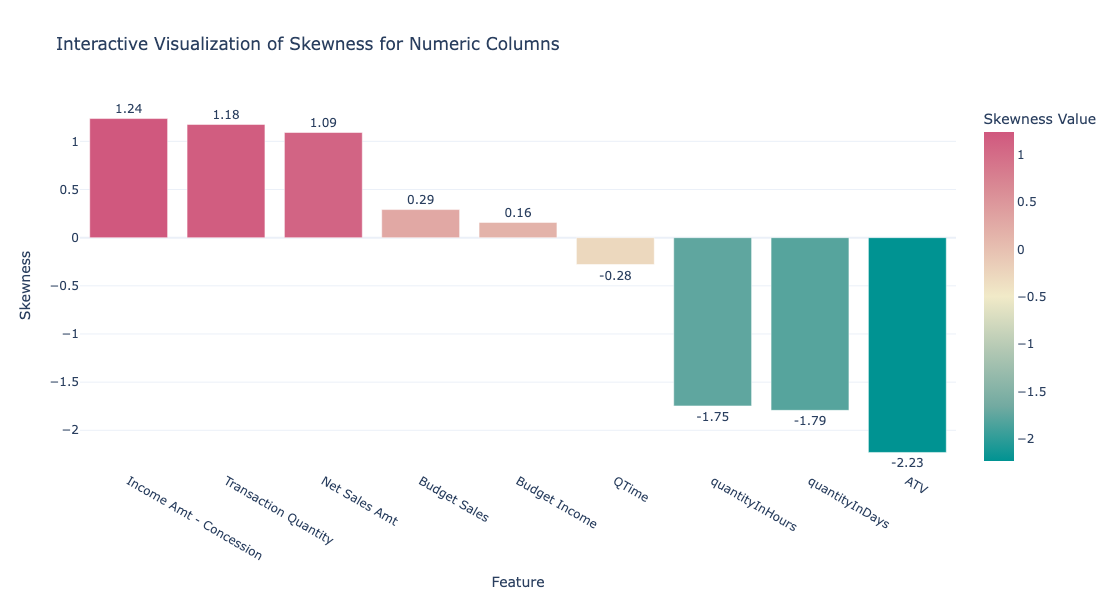

In [194]:
# Calculate skewness for all numeric columns
skewness = numeric_data.skew().sort_values(ascending=False).reset_index()
skewness.columns = ["Feature", "Skewness"]

# Create an interactive bar chart
fig = px.bar(
    skewness, 
    x="Feature", 
    y="Skewness", 
    text="Skewness", 
    color="Skewness",
    color_continuous_scale="Tealrose",
    title="Interactive Visualization of Skewness for Numeric Columns",
    labels={"Skewness": "Skewness Value", "Feature": "Features"}
)

# Customize layout for a cleaner look
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.update_layout(
    xaxis_title="Feature",
    yaxis_title="Skewness",
    template="plotly_white",
    showlegend=False,
    height=600
)

fig.show()

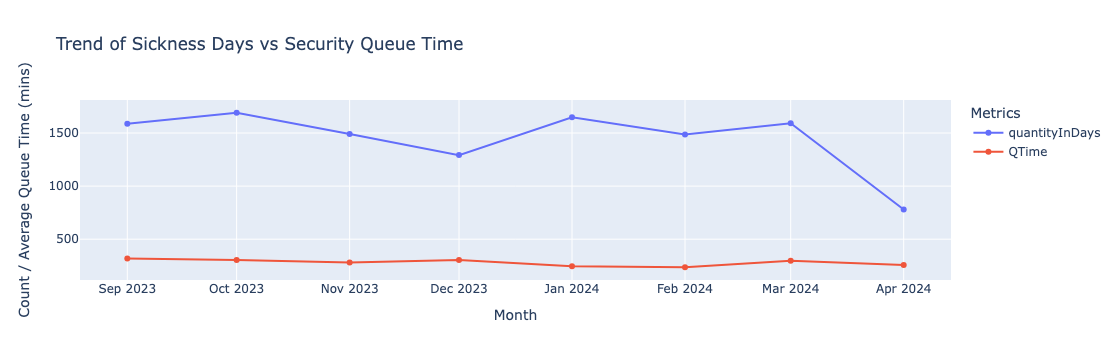

In [195]:
# Prepare data for merging sickness and security trends by month
sickness_trend["Month"] = pd.to_datetime(sickness_trend["Month"])
security_trend["Month"] = pd.to_datetime(security_trend["Month"])

# Merge sickness and security trends for visualization
merged_trend = pd.merge(sickness_trend, security_trend, on="Month", how="inner")

# Create an interactive line plot for sickness days vs security queue time
fig1 = px.line(
    merged_trend,
    x="Month",
    y=["quantityInDays", "QTime"],
    markers=True,
    title="Trend of Sickness Days vs Security Queue Time",
    labels={
        "Month": "Month",
        "value": "Count / Minutes",
        "variable": "Metric"
    }
)

# Customize layout for better appearance
fig1.update_layout(
    xaxis_title="Month",
    yaxis_title="Count / Average Queue Time (mins)",
    legend_title="Metrics",
    xaxis_tickformat="%b %Y",
    hovermode="x unified"
)

# Show the interactive plot
fig1.show()

Retail Sales by Store Type

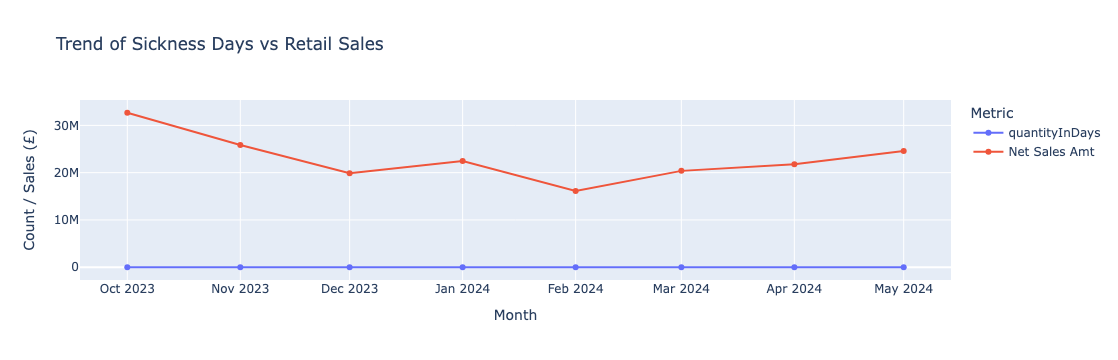

In [197]:
# Prepare the data for interactive visualization
merged_retail_trend["Month"] = pd.to_datetime(merged_retail_trend["Month"])

# Create an interactive line chart
fig = px.line(
    merged_retail_trend,
    x="Month",
    y=["quantityInDays", "Net Sales Amt"],
    markers=True,
    title="Trend of Sickness Days vs Retail Sales",
    labels={"value": "Count / Sales (£)", "Month": "Month", "variable": "Metric"}
)

# Customize layout for better readability
fig.update_layout(
    xaxis_title="Month",
    yaxis_title="Count / Sales (£)",
    hovermode="x unified",
    xaxis_tickformat="%b %Y"
)

# Show the interactive plot
fig.show()

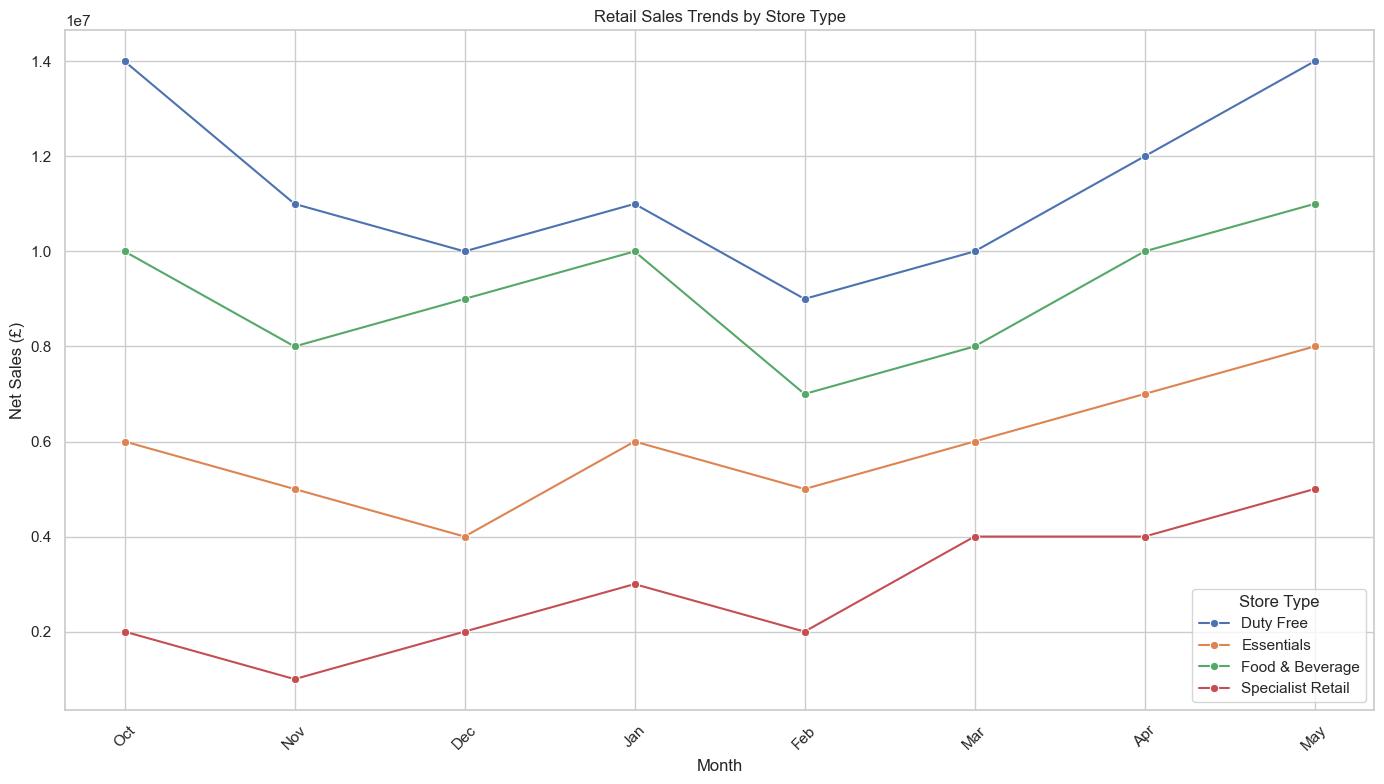

In [198]:
# Sample data to illustrate the structure, replace with actual data
data = {
    'Month': ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May'] * 4,
    'Store Type': ['Duty Free'] * 8 + ['Essentials'] * 8 + ['Food & Beverage'] * 8 + ['Specialist Retail'] * 8,
    'Net Sales (£)': [
        1.4e7, 1.1e7, 1.0e7, 1.1e7, 0.9e7, 1.0e7, 1.2e7, 1.4e7,  # Duty Free
        0.6e7, 0.5e7, 0.4e7, 0.6e7, 0.5e7, 0.6e7, 0.7e7, 0.8e7,  # Essentials
        1.0e7, 0.8e7, 0.9e7, 1.0e7, 0.7e7, 0.8e7, 1.0e7, 1.1e7,  # Food & Beverage
        0.2e7, 0.1e7, 0.2e7, 0.3e7, 0.2e7, 0.4e7, 0.4e7, 0.5e7   # Specialist Retail
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set the plot style
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(14, 8))
sns.lineplot(
    data=df,
    x="Month",
    y="Net Sales (£)",
    hue="Store Type",
    marker="o"
)

# Customizing the plot
plt.title("Retail Sales Trends by Store Type")
plt.xlabel("Month")
plt.ylabel("Net Sales (£)")
plt.xticks(rotation=45)
plt.legend(title="Store Type")
plt.tight_layout()

# Show the plot
plt.show()


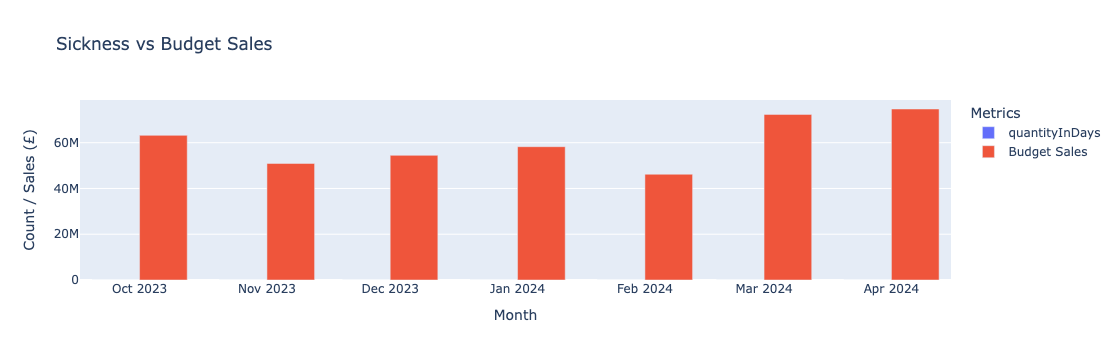

In [199]:
# Interactive bar chart for sickness impact on budget sales
fig = px.bar(merged_data, x="Month", y=["quantityInDays", "Budget Sales"], barmode="group",
             title="Sickness vs Budget Sales",
             labels={"value": "Count / Sales (£)", "variable": "Metrics"})
fig.show()


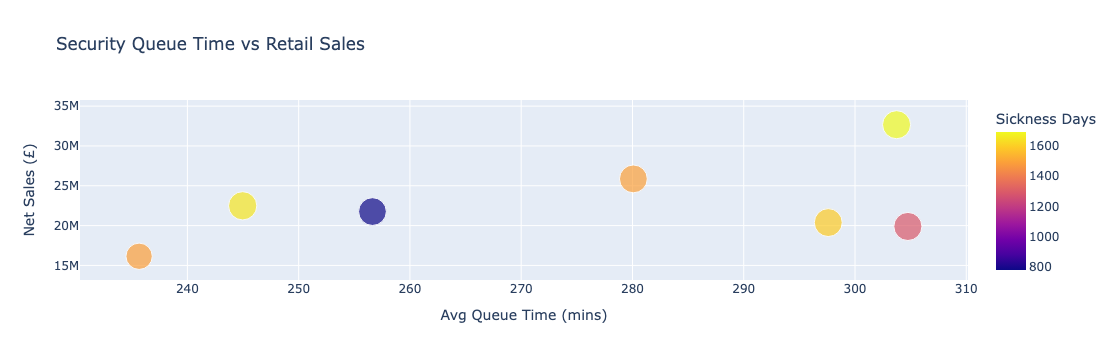

In [200]:
# Scatter plot for understanding how queue times relate to sales
fig2 = px.scatter(merged_data, x="QTime", y="Net Sales Amt", size="ATV", color="quantityInDays",
                 title="Security Queue Time vs Retail Sales",
                 labels={"QTime": "Avg Queue Time (mins)", "Net Sales Amt": "Net Sales (£)", "quantityInDays": "Sickness Days"})
fig2.show()

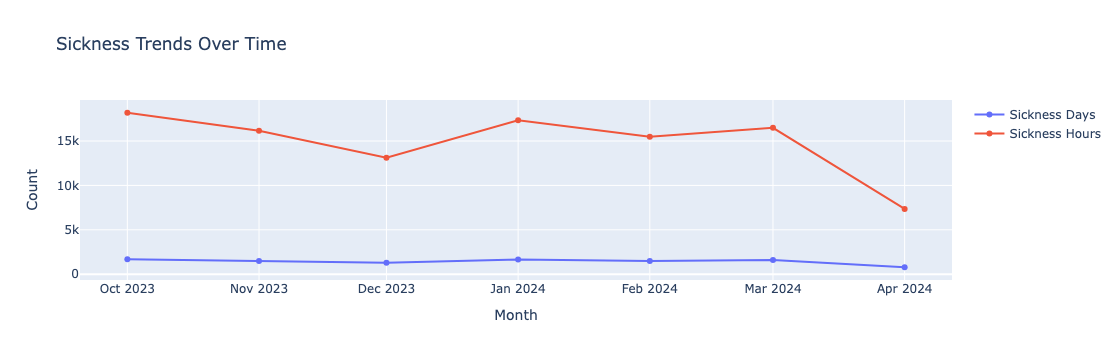

In [201]:
# Time-series analysis for sickness trends across months
fig = go.Figure()
fig.add_trace(go.Scatter(x=merged_data["Month"], y=merged_data["quantityInDays"],
                         mode='lines+markers', name='Sickness Days'))
fig.add_trace(go.Scatter(x=merged_data["Month"], y=merged_data["quantityInHours"],
                         mode='lines+markers', name='Sickness Hours'))
fig.update_layout(title="Sickness Trends Over Time",
                  xaxis_title="Month",
                  yaxis_title="Count",
                  hovermode="x unified")
fig.show()


In [202]:
# Segmenting data by terminal to analyze impact on different areas
sickness_terminal = sickness_df.groupby(["Month", "Terminal Name"])["quantityInDays"].sum().reset_index()

In [203]:
# Convert Month column to string to avoid JSON serialization issue
sickness_terminal["Month"] = sickness_terminal["Month"].astype(str)

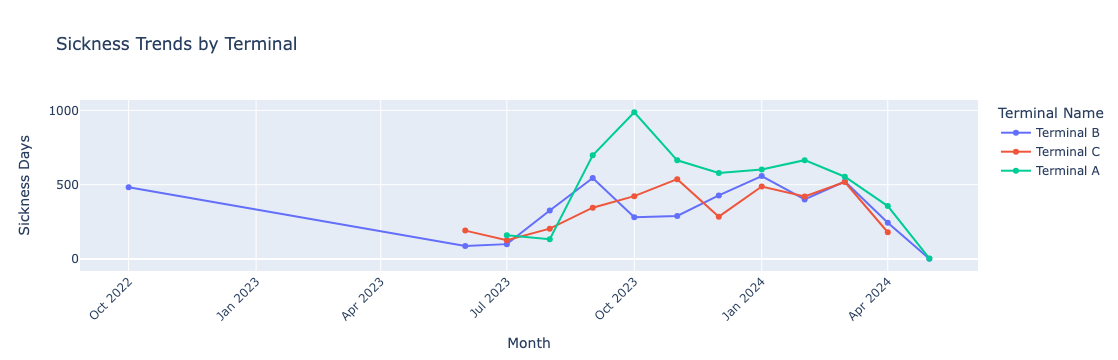

In [204]:
#Interactive visualization of sickness trends by terminal
fig = px.line(sickness_terminal, x="Month", y="quantityInDays", color="Terminal Name",
              markers=True, title="Sickness Trends by Terminal",
              labels={"quantityInDays": "Sickness Days", "Month": "Month"})
fig.update_layout(xaxis_tickangle=-45, hovermode="x unified")
fig.show()

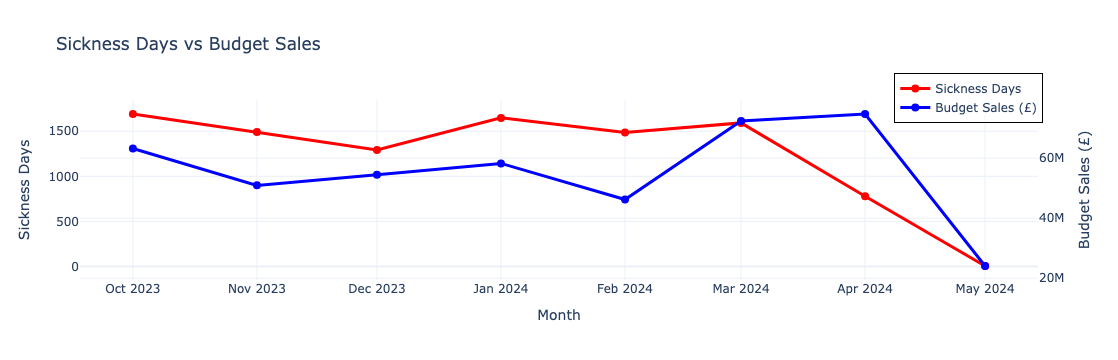

In [205]:
# Convert 'Month' to datetime format in both DataFrames
sickness_trend["Month"] = pd.to_datetime(sickness_trend["Month"], errors='coerce')
retail_trend["Month"] = pd.to_datetime(retail_trend["Month"], errors='coerce')

# Merge the two DataFrames on 'Month'
merged_budget_sales = pd.merge(sickness_trend, retail_trend, on="Month", how="inner")

# Create a dual-axis interactive line chart
fig= go.Figure()

# Add Sickness Days line
fig.add_trace(go.Scatter(
    x=merged_budget_sales["Month"],
    y=merged_budget_sales["quantityInDays"],
    mode='lines+markers',
    name='Sickness Days',
    line=dict(color='red', width=3),
    marker=dict(size=8)
))

# Add Budget Sales line (secondary axis)
fig.add_trace(go.Scatter(
    x=merged_budget_sales["Month"],
    y=merged_budget_sales["Budget Sales"],
    mode='lines+markers',
    name='Budget Sales (£)',
    line=dict(color='blue', width=3),
    marker=dict(size=8),
    yaxis="y2"
))

# Update layout for dual-axis chart with legend in the top right corner
fig.update_layout(
    title="Sickness Days vs Budget Sales",
    xaxis=dict(title="Month", tickformat="%b %Y"),
    yaxis=dict(title="Sickness Days", side="left"),
    yaxis2=dict(title="Budget Sales (£)", overlaying="y", side="right"),
    legend=dict(
        x=0.85,  # Adjust the horizontal position
        y=1.15,  # Adjust the vertical position
        bgcolor='rgba(255,255,255,0.5)',  # Set background with transparency
        bordercolor='black',
        borderwidth=1
    ),
    hovermode="x unified",
    template="plotly_white"
)

# Show the interactive chart
fig.show()

In [206]:
# Correlation Analysis

In [207]:
print("Columns in merged_data:", merged_data.columns)

Columns in merged_data: Index(['Month', 'quantityInDays', 'quantityInHours', 'QTime',
       'Income Amt - Concession', 'Budget Income', 'Net Sales Amt',
       'Budget Sales', 'Transaction Quantity', 'ATV'],
      dtype='object')


In [208]:
#print numeric columns for correlation analysis
print("Columns in numeric_data:", numeric_data.columns)

Columns in numeric_data: Index(['QTime', 'Income Amt - Concession', 'Budget Income', 'Net Sales Amt',
       'Budget Sales', 'Transaction Quantity', 'ATV', 'quantityInDays',
       'quantityInHours'],
      dtype='object')


In [209]:
# Compute correlation matrix
correlation_matrix = numeric_data.corr()

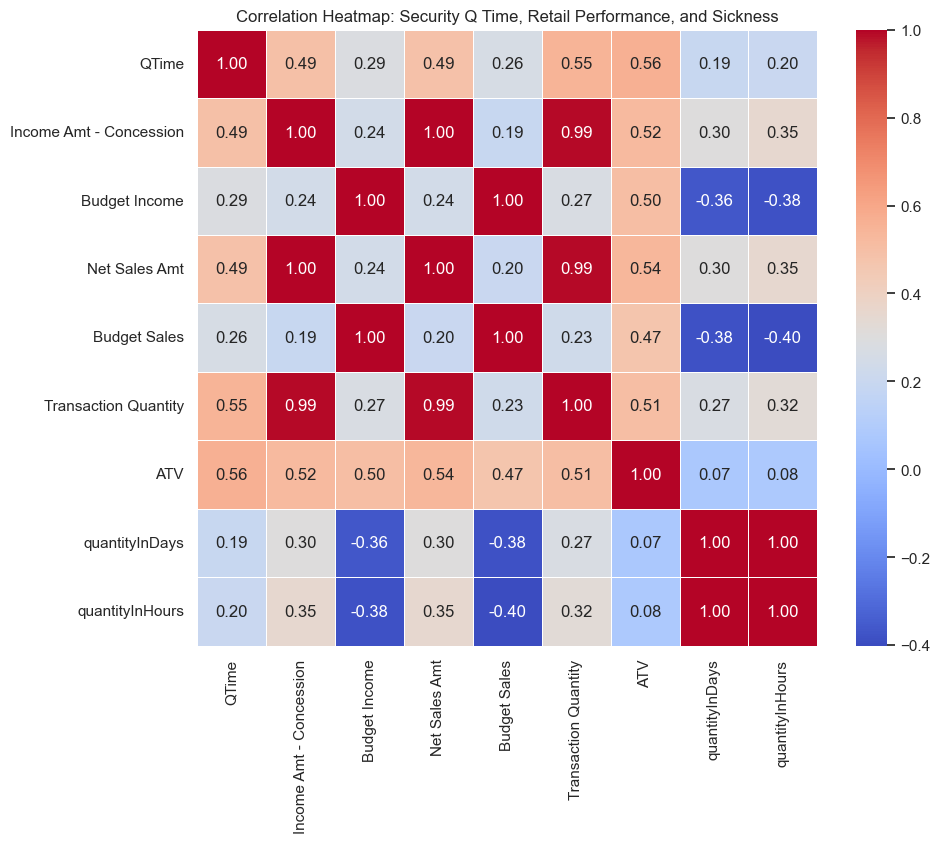

In [210]:
# Visualizing correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Security Q Time, Retail Performance, and Sickness")
plt.show()

In [211]:
# Ensure that only numeric columns are used in correlation analysis
numeric_columns = merged_data.select_dtypes(include=[np.number]).columns
corr_matrix = merged_data[numeric_columns].corr()


In [212]:

# Initialize Dash App
app = dash.Dash(__name__)

# Define Figures
fig1 = go.Figure()

# Create an interactive line plot for sickness days vs security queue time
fig1 = px.line(
    merged_trend,
    x="Month",
    y=["quantityInDays", "QTime"],
    markers=True,
    title="Trend of Sickness Days vs Security Queue Time",
    labels={
        "Month": "Month",
        "value": "Count / Minutes",
        "variable": "Metric"
    }
)

# Customize layout for better appearance
fig1.update_layout(
    xaxis_title="Month",
    yaxis_title="Count / Average Queue Time (mins)",
    legend_title="Metrics",
    xaxis_tickformat="%b %Y",
    hovermode="x unified"
)


# Scatter plot for security queue time vs retail sales
fig2 = px.scatter(
    merged_data, x="QTime", y="Net Sales Amt", size="ATV", color="quantityInDays",
    title="Security Queue Time vs Retail Sales",
    labels={"QTime": "Avg Queue Time (mins)", "Net Sales Amt": "Net Sales (£)", "quantityInDays": "Sickness Days"},
    template="plotly_white"
)
fig2.update_traces(marker=dict(opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))


#Interactive visualization of sickness trends by terminal
fig3 = px.line(sickness_terminal, x="Month", y="quantityInDays", color="Terminal Name",
              markers=True, title="Sickness Trends by Terminal",
              labels={"quantityInDays": "Sickness Days", "Month": "Month"})
fig3.update_layout(xaxis_tickangle=-45, hovermode="x unified")


# Heatmap for correlation analysis
fig4 = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,
    colorscale="Viridis",
    zmin=-1, zmax=1,
    text=np.round(corr_matrix.values, 2),
    texttemplate="%{text}",
    hoverinfo="z"
))
fig4.update_layout(
    title="Correlation Heatmap: Sickness, Security & Retail",
    xaxis_title="Features",
    yaxis_title="Features",
    margin=dict(l=50, r=50, t=50, b=50),
    autosize=True
)

# Dash Layout with a professional-looking structure
app.layout = html.Div(style={'backgroundColor': '#F5F7FA', 'padding': '20px'}, children=[

    html.H1("Actionable Insights Dashboard", 
            style={'textAlign': 'center', 'color': '#333', 'fontSize': '26px', 'marginBottom': '20px'}),

    html.Div([
        html.Div([
            dcc.Graph(figure=fig1)
        ], className="six columns", style={'padding': '10px'}),

        html.Div([
            dcc.Graph(figure=fig2)
        ], className="six columns", style={'padding': '10px'}),
    ], className="row"),

    html.Div([
        html.Div([
            dcc.Graph(figure=fig3)
        ], className="six columns", style={'padding': '10px'}),

        html.Div([
            dcc.Graph(figure=fig4)
        ], className="six columns", style={'padding': '10px'}),
    ], className="row"),

])

# Run Dash App
if __name__ == '__main__':
    app.run_server(debug=True)


Prediction Model Building for Sickness Days

In [214]:
print(merged_data.columns)


Index(['Month', 'quantityInDays', 'quantityInHours', 'QTime',
       'Income Amt - Concession', 'Budget Income', 'Net Sales Amt',
       'Budget Sales', 'Transaction Quantity', 'ATV'],
      dtype='object')


Mean Absolute Error (MAE): 137.55500000000006
Root Mean Squared Error (RMSE): 154.9794310545758


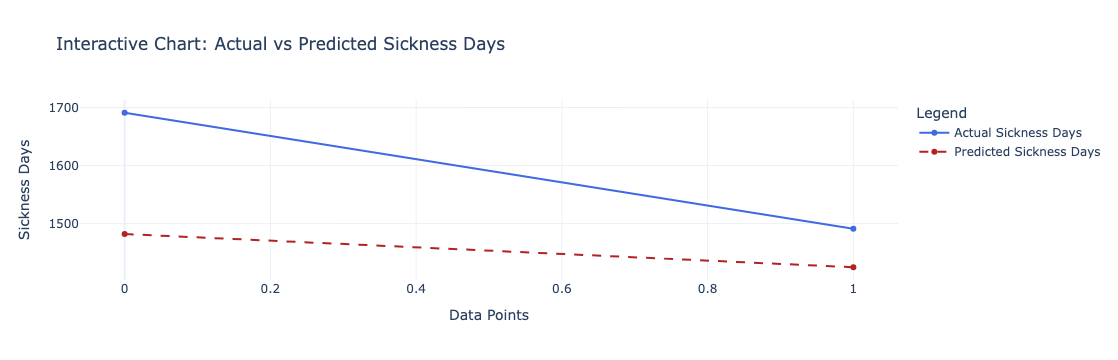

In [215]:
# Prepare your data
X = merged_data[["Budget Sales","ATV", "quantityInHours", "QTime"]]
y = merged_data["quantityInDays"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

# Interactive Visualization of Actual vs Predicted
import plotly.graph_objects as go

fig = go.Figure()

# Add actual sickness days
fig.add_trace(go.Scatter(
    x=list(range(len(y_test))),
    y=y_test.values,
    mode='lines+markers',
    name='Actual Sickness Days',
    line=dict(color='royalblue')
))

# Add predicted sickness days
fig.add_trace(go.Scatter(
    x=list(range(len(y_pred))),
    y=y_pred,
    mode='lines+markers',
    name='Predicted Sickness Days',
    line=dict(color='firebrick', dash='dash')
))

# Update layout for a clean look
fig.update_layout(
    title="Interactive Chart: Actual vs Predicted Sickness Days",
    xaxis_title="Data Points",
    yaxis_title="Sickness Days",
    template="plotly_white",
    legend_title="Legend",
    hovermode="x unified"
)

fig.show()



In [216]:
model = RandomForestRegressor(random_state=42)
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))


quantityInHours    0.371392
Budget Sales       0.358851
ATV                0.167533
QTime              0.102223
dtype: float64


MAE of 137 days means that, on average, the predicted sickness days are 137 days off from the actual values.
#If the true sickness for a month is 1,000 days, the prediction could be around 863 or 1,137 days.

An RMSE of 155 days means that the typical deviation between actual and predicted sickness days is around 155.

Model Comparison

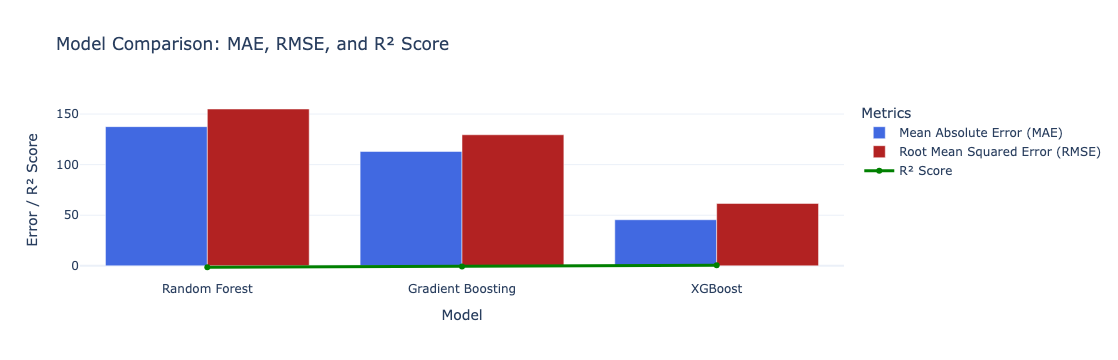

Best Model based on MAE: XGBoost
               Model         MAE        RMSE  R² Score
0      Random Forest  137.555000  154.979431 -1.401862
1  Gradient Boosting  113.004076  129.517121 -0.677468
2            XGBoost   45.542725   61.643717  0.620005


In [220]:

# Prepare your data
X = merged_data[["Budget Sales", "ATV", "quantityInHours", "QTime"]]
y = merged_data["quantityInDays"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Store evaluation metrics
results = []

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R² Score": r2})

# Convert results to a DataFrame for visualization
results_df = pd.DataFrame(results)

# Interactive Visualization of Model Comparison
fig = go.Figure()

# Add MAE to the chart
fig.add_trace(go.Bar(
    x=results_df["Model"],
    y=results_df["MAE"],
    name="Mean Absolute Error (MAE)",
    marker_color="royalblue"
))

# Add RMSE to the chart
fig.add_trace(go.Bar(
    x=results_df["Model"],
    y=results_df["RMSE"],
    name="Root Mean Squared Error (RMSE)",
    marker_color="firebrick"
))

# Add R² Score to the chart
fig.add_trace(go.Scatter(
    x=results_df["Model"],
    y=results_df["R² Score"],
    mode="lines+markers",
    name="R² Score",
    line=dict(color="green", width=3)
))

# Update layout for a clean and professional look
fig.update_layout(
    title="Model Comparison: MAE, RMSE, and R² Score",
    xaxis_title="Model",
    yaxis_title="Error / R² Score",
    template="plotly_white",
    legend_title="Metrics",
    barmode="group",
    hovermode="x unified"
)

fig.show()

# Print the best model based on MAE
best_model = results_df.loc[results_df["MAE"].idxmin()]
print("Best Model based on MAE:", best_model["Model"])
print(results_df)


MAE of 45 days means that, on average, the predicted sickness days are 45 days off from the actual values. If the true sickness for a month is 1,000 days, the prediction could be around 955 or 1045 days.

An RMSE of 62 days means that the typical deviation between actual and predicted sickness days is around 62.

Model Comparision after Hyperparameter Tuning 

Tuning hyperparameters for Random Forest...
Random Forest - Best Params: {'n_estimators': 100, 'min_samples_split': 5, 'max_depth': None}

Tuning hyperparameters for Gradient Boosting...
Gradient Boosting - Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}

Tuning hyperparameters for XGBoost...
XGBoost - Best Params: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1}



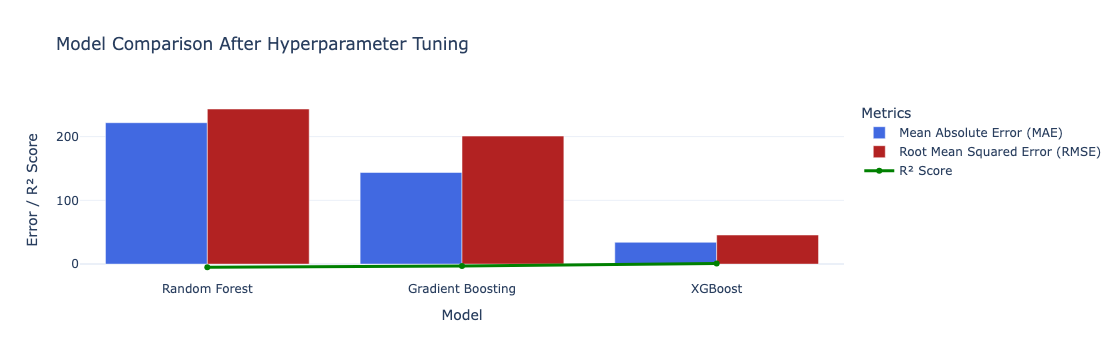

Best Model after Hyperparameter Tuning: XGBoost
               Model         MAE        RMSE  R² Score
0      Random Forest  221.740000  243.246023 -4.916863
1  Gradient Boosting  143.687819  200.788110 -3.031587
2            XGBoost   34.207886   45.635754  0.791738


In [224]:

# Prepare your data
X = merged_data[["Budget Sales", "ATV", "quantityInHours", "QTime"]]
y = merged_data["quantityInDays"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        "n_estimators": [100, 200, 300],
        "max_depth": [10, 20, 30, None],
        "min_samples_split": [2, 5, 10]
    },
    "Gradient Boosting": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    },
    "XGBoost": {
        "n_estimators": [100, 200, 300],
        "learning_rate": [0.01, 0.1, 0.2],
        "max_depth": [3, 5, 7]
    }
}

# Models for tuning
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Store the evaluation results
results = []

for name, model in models.items():
    print(f"Tuning hyperparameters for {name}...")
    
    # Randomized search for hyperparameter tuning
    search = RandomizedSearchCV(model, param_grids[name], cv=3, n_iter=10, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
    search.fit(X_train, y_train)
    
    # Best model after tuning
    best_model = search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R² Score": r2})
    print(f"{name} - Best Params: {search.best_params_}\n")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Interactive Visualization
fig = go.Figure()

# Add MAE to the chart
fig.add_trace(go.Bar(
    x=results_df["Model"],
    y=results_df["MAE"],
    name="Mean Absolute Error (MAE)",
    marker_color="royalblue"
))

# Add RMSE to the chart
fig.add_trace(go.Bar(
    x=results_df["Model"],
    y=results_df["RMSE"],
    name="Root Mean Squared Error (RMSE)",
    marker_color="firebrick"
))

# Add R² Score to the chart
fig.add_trace(go.Scatter(
    x=results_df["Model"],
    y=results_df["R² Score"],
    mode="lines+markers",
    name="R² Score",
    line=dict(color="green", width=3)
))

# Update layout for a clean and professional look
fig.update_layout(
    title="Model Comparison After Hyperparameter Tuning",
    xaxis_title="Model",
    yaxis_title="Error / R² Score",
    template="plotly_white",
    legend_title="Metrics",
    barmode="group",
    hovermode="x unified"
)

fig.show()

# Print the best model based on MAE
best_model = results_df.loc[results_df["MAE"].idxmin()]
print("Best Model after Hyperparameter Tuning:", best_model["Model"])
print(results_df)


MAE of 34 days means that, on average, the predicted sickness days are 34 days off from the actual values. If the true sickness for a month is 1,000 days, the prediction could be around 966 or 1034 days.

An RMSE of 46 days means that the typical deviation between actual and predicted sickness days is around 46.

R² = 0.79  
Approx 80% of the variation in the target variable is explained by the model.

Cross Validation Results

Performing cross-validation for Random Forest...
Performing cross-validation for Gradient Boosting...
Performing cross-validation for XGBoost...


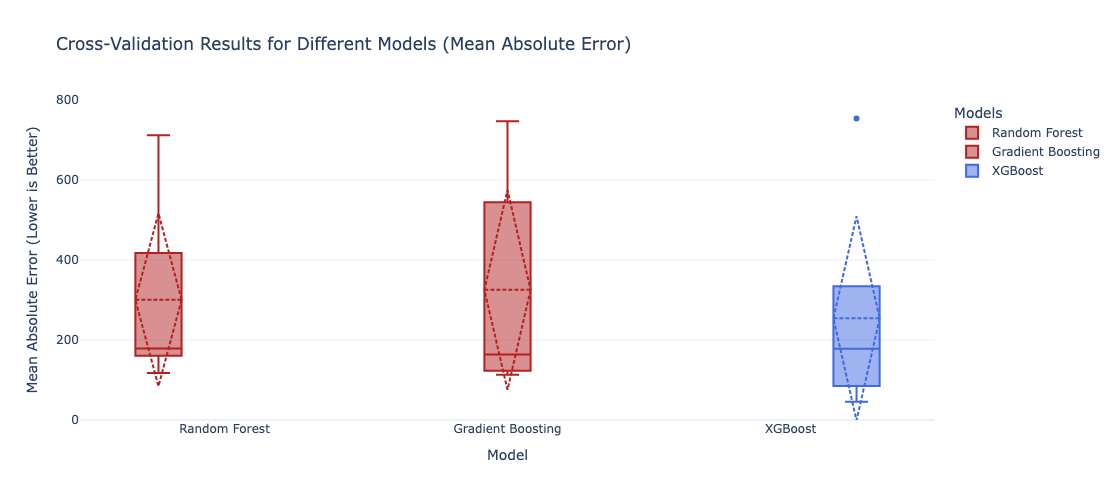

The best model based on cross-validation is: XGBoost


In [229]:
# Prepare your data
X = merged_data[["Budget Sales", "ATV", "quantityInHours", "QTime"]]
y = merged_data["quantityInDays"]

# Models for cross-validation
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

# Store cross-validation results
cv_results = {}

for name, model in models.items():
    print(f"Performing cross-validation for {name}...")
    # Perform cross-validation with MAE as the scoring metric
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
    cv_results[name] = -scores  # Convert to positive for plotting

# Plot the cross-validation results
fig = go.Figure()

for model_name, scores in cv_results.items():
    color = 'royalblue' if model_name == "XGBoost" else 'firebrick'
    fig.add_trace(go.Box(
        y=scores,
        name=model_name,
        boxmean='sd',  # Show the mean and standard deviation
        marker=dict(color=color),
        line=dict(width=2)
    ))

# Update layout to match the style in your uploaded image
fig.update_layout(
    title="Cross-Validation Results for Different Models (Mean Absolute Error)",
    yaxis=dict(
        title="Mean Absolute Error (Lower is Better)",
        tickvals=[0, 200, 400, 600, 800],  # Custom tick values
        range=[0, 800]
    ),
    xaxis_title="Model",
    template="plotly_white",
    boxmode="group",
    legend_title="Models",
    height=500,
    width=1000,
    hovermode="x unified"
)

fig.show()

# Find the best model based on the average cross-validation score
best_model_name = min(cv_results, key=lambda x: cv_results[x].mean())
print(f"The best model based on cross-validation is: {best_model_name}")
